# Differential Expression Analysis using DeSeq2

In [1]:
library(readr)
count_matrix <- read_csv("/home/jovyan/GSE164073_Eye_count_matrix.csv")  
dim(count_matrix)
head(count_matrix, 3)

Rows: 27946 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Gene
dbl (18): MW1_cornea_mock_1, MW2_cornea_mock_2, MW3_cornea_mock_3, MW4_corne...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 27946    19

Gene     MW1_cornea_mock_1 MW2_cornea_mock_2 MW3_cornea_mock_3
1 A1BG      91               131                86              
2 A1BG-AS1 292               284               271              
3 A1CF       0                 0                 0              
  MW4_cornea_CoV2_1 MW5_cornea_CoV2_2 MW6_cornea_CoV2_3 MW7_limbus_mock_1
1  77                69                72               128              
2 232               250               241               444              
3   0                 0                 0                 0              
  MW8_limbus_mock_2 MW9_limbus_mock_3 MW10_limbus_CoV2_1 MW11_limbus_CoV2_2
1  97               112                96                 95               
2 311               355               274                298               
3   0                 0                 0                  0               
  MW12_limbus_CoV2_3 MW13_sclera_mock_1 MW14_sclera_mock_2 MW15_sclera_mock_3
1  82                 82                 70                101               
2 322                233                241                243               
3   0                  0                  0                  0               
  MW16_sclera_CoV2_1 MW17_sclera_CoV2_2 MW18_sclera_CoV2_3
1  91                 78                 84               
2 279                203                278               
3   0                  0                  0

## Preprocessing


In [2]:
count_matrix <- as.data.frame(count_matrix)  # convert tibble to data.frame

# Set gene symbols as row names
rownames(count_matrix) <- count_matrix$Gene

# Remove the Gene column so only numeric counts remain
count_matrix <- count_matrix[, -which(names(count_matrix) == "Gene")]

# Ensure counts are integers
count_matrix[] <- lapply(count_matrix, function(x) as.integer(round(x)))

# check data
#head(count_matrix, 3)

## Create metadata

In [3]:
sample_names <- colnames(count_matrix)

# Suppose the 19 samples are in order:
# 6 cornea (3 mock + 3 CoV2), 6 limbus (3 mock + 3 CoV2), 6 sclera (3 mock + 3 CoV2), + 1 extra?
# Adjust as needed to match your dataset
tissue <- c(rep("cornea",6), rep("limbus",6), rep("sclera",6))
condition <- c(rep(c("mock","CoV2"), each=3), rep(c("mock","CoV2"), each=3), rep(c("mock","CoV2"), each=3))

# Build colData
colData <- data.frame(tissue = tissue, condition = condition)
rownames(colData) <- sample_names

# Check
nrow(colData)   # should be 19
ncol(count_matrix)  # should be 19
head(colData,4)

[1] 18

[1] 18

tissue condition
MW1_cornea_mock_1 cornea mock     
MW2_cornea_mock_2 cornea mock     
MW3_cornea_mock_3 cornea mock     
MW4_cornea_CoV2_1 cornea CoV2

In [4]:
## Check if all column names in count_matrix are in colData or metadata rownames

all(colnames(count_matrix) %in% rownames(colData))

# Check if all colData rownames are in count_matrix columns

all(rownames(colData) %in% colnames(count_matrix))

#Check the order of samples

#DESeq2 requires row order in colData to match column order in count_matrix:

all(rownames(colData) == colnames(count_matrix))


[1] TRUE

[1] TRUE

[1] TRUE

## Differential expression analysis using DeSeq2

In [5]:

#install.packages("BiocManager")
#BiocManager::install(version = "3.18")  

#BiocManager::install("DESeq2")


In [6]:
library(DESeq2)

dds <- DESeqDataSetFromMatrix(
  countData =  round(count_matrix),
  colData = colData,
  design = ~ condition   
)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [7]:
##  Filtering before DeSeq2 creating

dds <- dds[rowSums(counts(dds)) >= 10, ]  # keep genes with ≥10 counts across all samples



In [8]:
## Run DESeq2
dds <- DESeq(dds)
res <- results(dds)


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [9]:
head(res)
# Save as CSV in Jupyter working directory
#write.csv(res_df, file = "/home/jovyan/DE_results.csv", row.names = TRUE)

log2 fold change (MLE): condition mock vs CoV2 
Wald test p-value: condition mock vs CoV2 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
A1BG      90.387769      0.1449492  0.117706  1.231452 0.2181537  0.775805
A1BG-AS1 278.108499      0.0490181  0.112583  0.435394 0.6632767  0.952794
A2M      872.917260      0.8098853  0.741530  1.092182 0.2747531  0.812063
A2M-AS1   11.330923     -0.4885154  0.252834 -1.932160 0.0533398        NA
A2ML1      0.578192      1.1192600  1.825458  0.613139 0.5397843        NA
A3GALT2    0.685671      0.1302514  1.222775  0.106521 0.9151688        NA

In [10]:
summary(res)


out of 17925 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 125, 0.7%
LFC < 0 (down)     : 183, 1%
outliers [1]       : 0, 0%
low counts [2]     : 4518, 25%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Filtering

In [11]:
# Filter out genes with significant p-values (padj < 0.05)
significant_genes <- res[!is.na(res$padj) & res$padj < 0.05, ]

# Identify upregulated genes (log2FoldChange > 0)
upregulated_genes <- significant_genes[significant_genes$log2FoldChange > 0, ]

# Identify downregulated genes (log2FoldChange < 0)
downregulated_genes <- significant_genes[significant_genes$log2FoldChange < 0, ]

# Get the total number of upregulated and downregulated genes
num_upregulated <- nrow(upregulated_genes)
num_downregulated <- nrow(downregulated_genes)

# Print the results
cat("Number of upregulated genes:", num_upregulated, "\n")
cat("Number of downregulated genes:", num_downregulated, "\n")


Number of upregulated genes: 83 
Number of downregulated genes: 146 


## MA plot

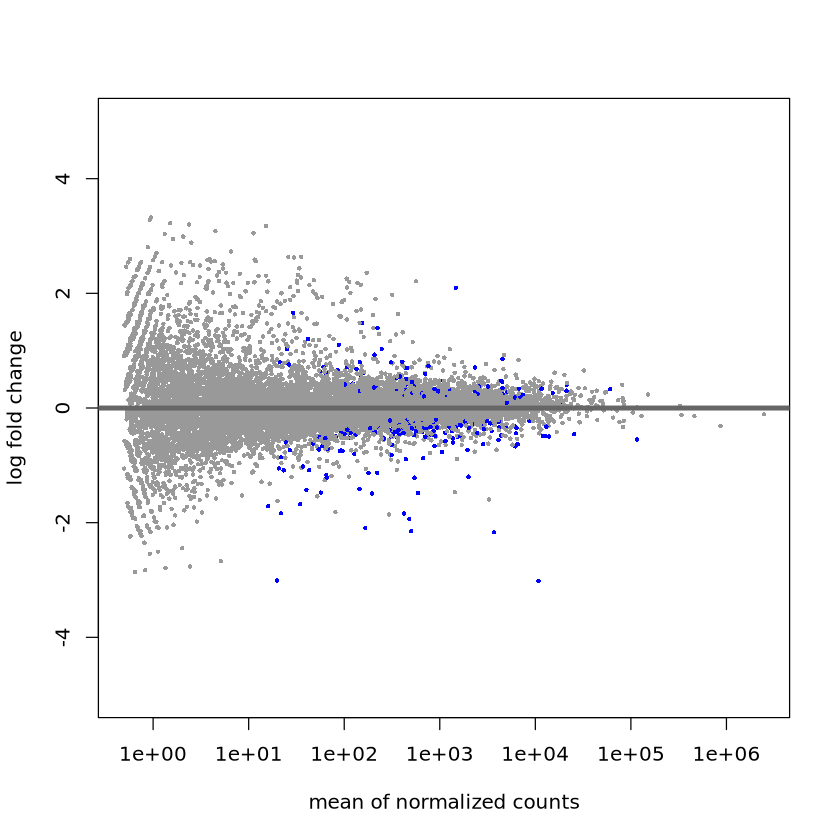

In [12]:
#options(repr.plot.width = 4, repr.plot.height = 3)  # width & height in inches
# Now plot MA
plotMA(res, ylim = c(-5, 5), cex = 0.5)

#In DESeq2, the MA plot is often used to visualize the effect of shrinkage estimators and to identify genes with significant differential expression, which are typically highlighted in color.

## PCA plot

using ntop=500 top features by variance

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


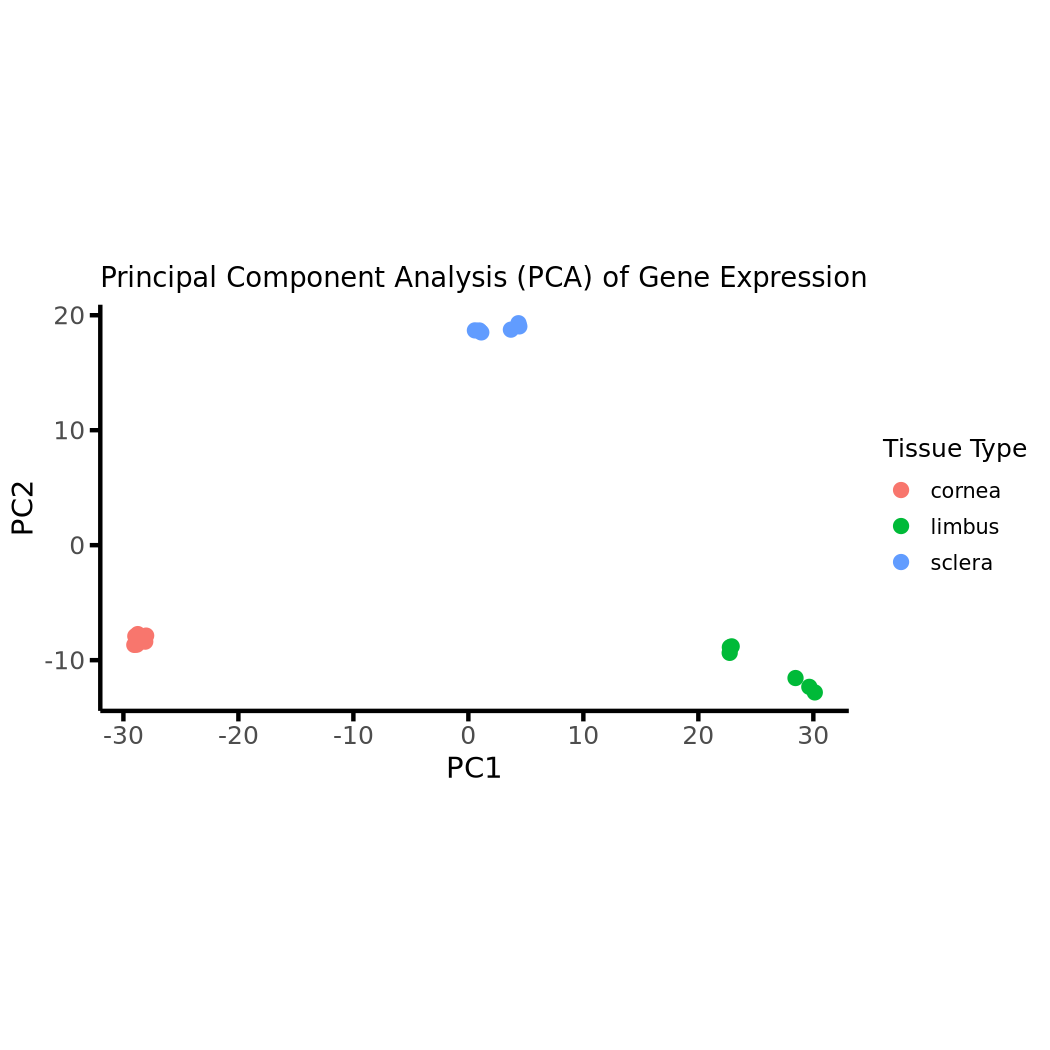

In [13]:
# Reduce the resolution of plots in the notebook to lower file size
options(repr.plot.res = 150)


library(ggplot2)

vsd <- vst(dds, blind = FALSE)

plotPCA(vsd, intgroup = "tissue", returnData = FALSE) + 
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10),
    panel.grid = element_blank(),
    axis.line = element_line(size = 1, color = "black"),
    axis.ticks = element_line(size = 1, color = "black"),
    axis.ticks.length = unit(0.07, "inches")
  ) +
  labs(
    title = "Principal Component Analysis (PCA) of Gene Expression",
    x = "PC1",
    y = "PC2",
    color = "Tissue Type"
  ) +
  theme(legend.position = "right")




## Plotting VolcanoPlot

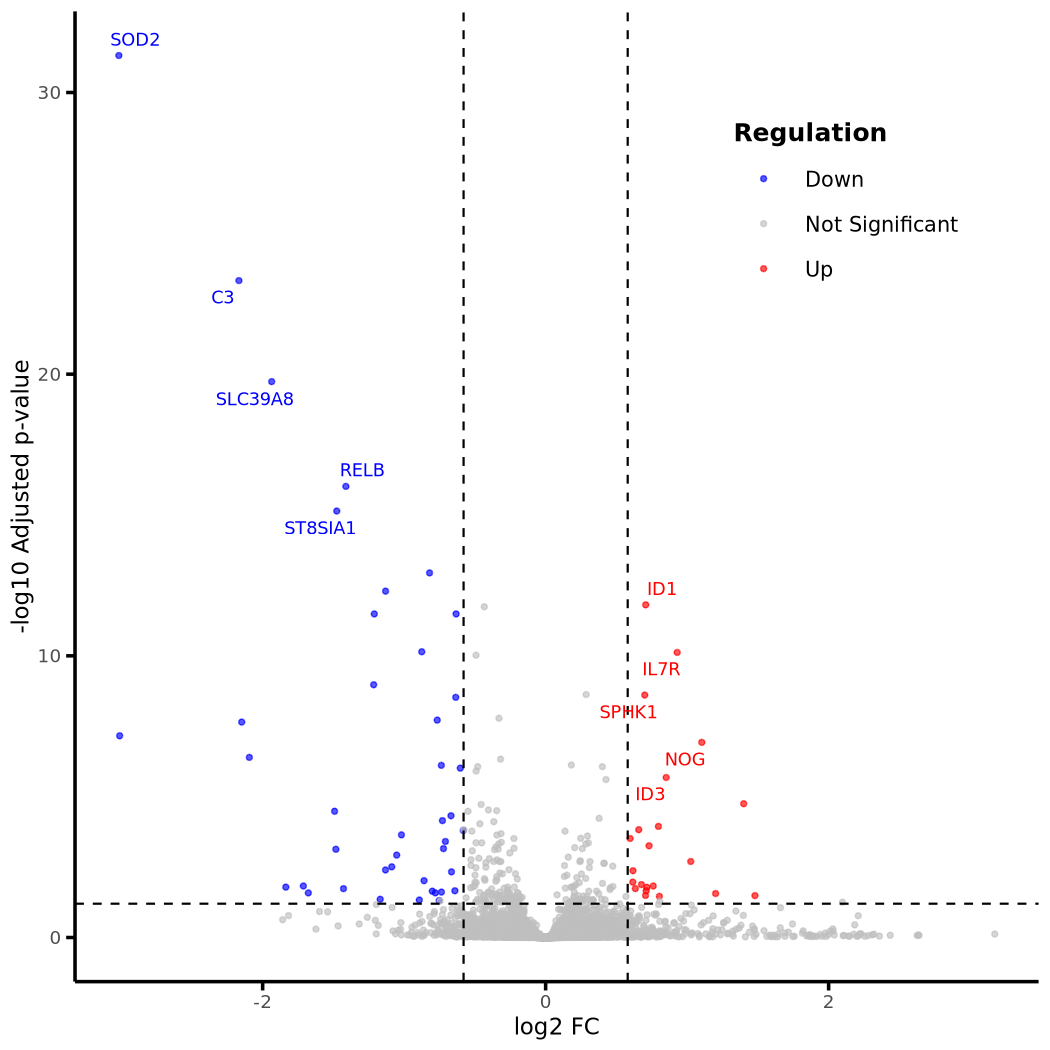

In [27]:
library(dplyr)
library(ggplot2)
library(ggrepel)

# Convert results to a data frame
res_df <- as.data.frame(res)

# Clean up results
res_df_clean <- res_df[!is.na(res_df$padj), ]

# Clean DESeq2 results
res_df_clean <- res_df[!is.na(res_df$padj), ]

# Add regulation status and convert to factor
res_df_clean <- res_df_clean %>%
  mutate(
    Regulation = case_when(
      log2FoldChange > 0.58 & padj < 0.05  ~ "Up",
      log2FoldChange < -0.58 & padj < 0.05 ~ "Down",
      TRUE ~ "Not Significant"  # Keep "Not Significant" for the rest
    ),
    Regulation = factor(Regulation, levels = c("Down", "Not Significant", "Up"))  # Define the factor levels
  )

# Filter points above -log10(padj) > 50
res_df_clean <- res_df_clean %>%
  filter(-log10(padj) <= 50)

# Select top 5 Up and Down genes
top_up <- res_df_clean %>% filter(Regulation == "Up") %>% arrange(padj) %>% slice_head(n = 5)
top_down <- res_df_clean %>% filter(Regulation == "Down") %>% arrange(padj) %>% slice_head(n = 5)
top_genes <- bind_rows(top_up, top_down)

# Volcano plot with enhanced aesthetics
volcano = ggplot(res_df_clean, aes(x = log2FoldChange, y = -log10(padj), color = Regulation)) +
  geom_point(alpha = 0.65, size = 1) +  # Keep only one geom_point() layer
  scale_color_manual(
    values = c("Down" = "blue", "Not Significant" = "grey", "Up" = "red"),  # Color for all 3 categories
    breaks = c("Down", "Not Significant", "Up")  # Ensure all categories are in the legend
  ) +
  geom_vline(xintercept = c(-0.58, 0.58), linetype = "dashed", color = "black") +  # threshold lines
  geom_hline(yintercept = 1.2, linetype = "dashed", color = "black") +         # significance threshold
  geom_text_repel(data = top_genes, aes(label = rownames(top_genes)), size = 3, max.overlaps = 50, show.legend = FALSE) +  # Disable legend for text labels
  theme_minimal() +
  theme(
    axis.line.y.left = element_line(color = "black", size = 0.8),  # Solid left y-axis
    axis.line.x = element_line(color = "black", linewidth = 0.8),       # Solid x-axis
    axis.line.y.right = element_blank(),                            # Remove right y-axis
    legend.position = c(0.8, 0.8),                                  # Custom position for the legend (X = 0.8, Y = 0.8)
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10),
    legend.key.height = unit(1.5, "lines"), 
    legend.key.width = unit(2, "lines"),
    legend.spacing.y = unit(0.5, "cm"),  # Increase space between items in the legend
    legend.box.spacing = unit(0.5, "cm"),  # Adjust space around the legend box
    axis.ticks.length = unit(0.1, "cm"),                             # Increase the tick length
    axis.ticks = element_line(color = "black", size = 0.8),         # Black color and size for ticks
    axis.ticks.length.x = unit(0.15, "cm"),
    axis.ticks.length.y = unit(0.15, "cm"),
    panel.grid.major = element_blank(),   # Remove major grid lines
    panel.grid.minor = element_blank()    # Remove minor grid lines
  ) +
  labs(
    x = "log2 FC",
    y = "-log10 Adjusted p-value"
  )

# Display the plot
volcano 


## Heatmap

In [15]:
install.packages("pheatmap")


Installing package into ‘/home/jovyan/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



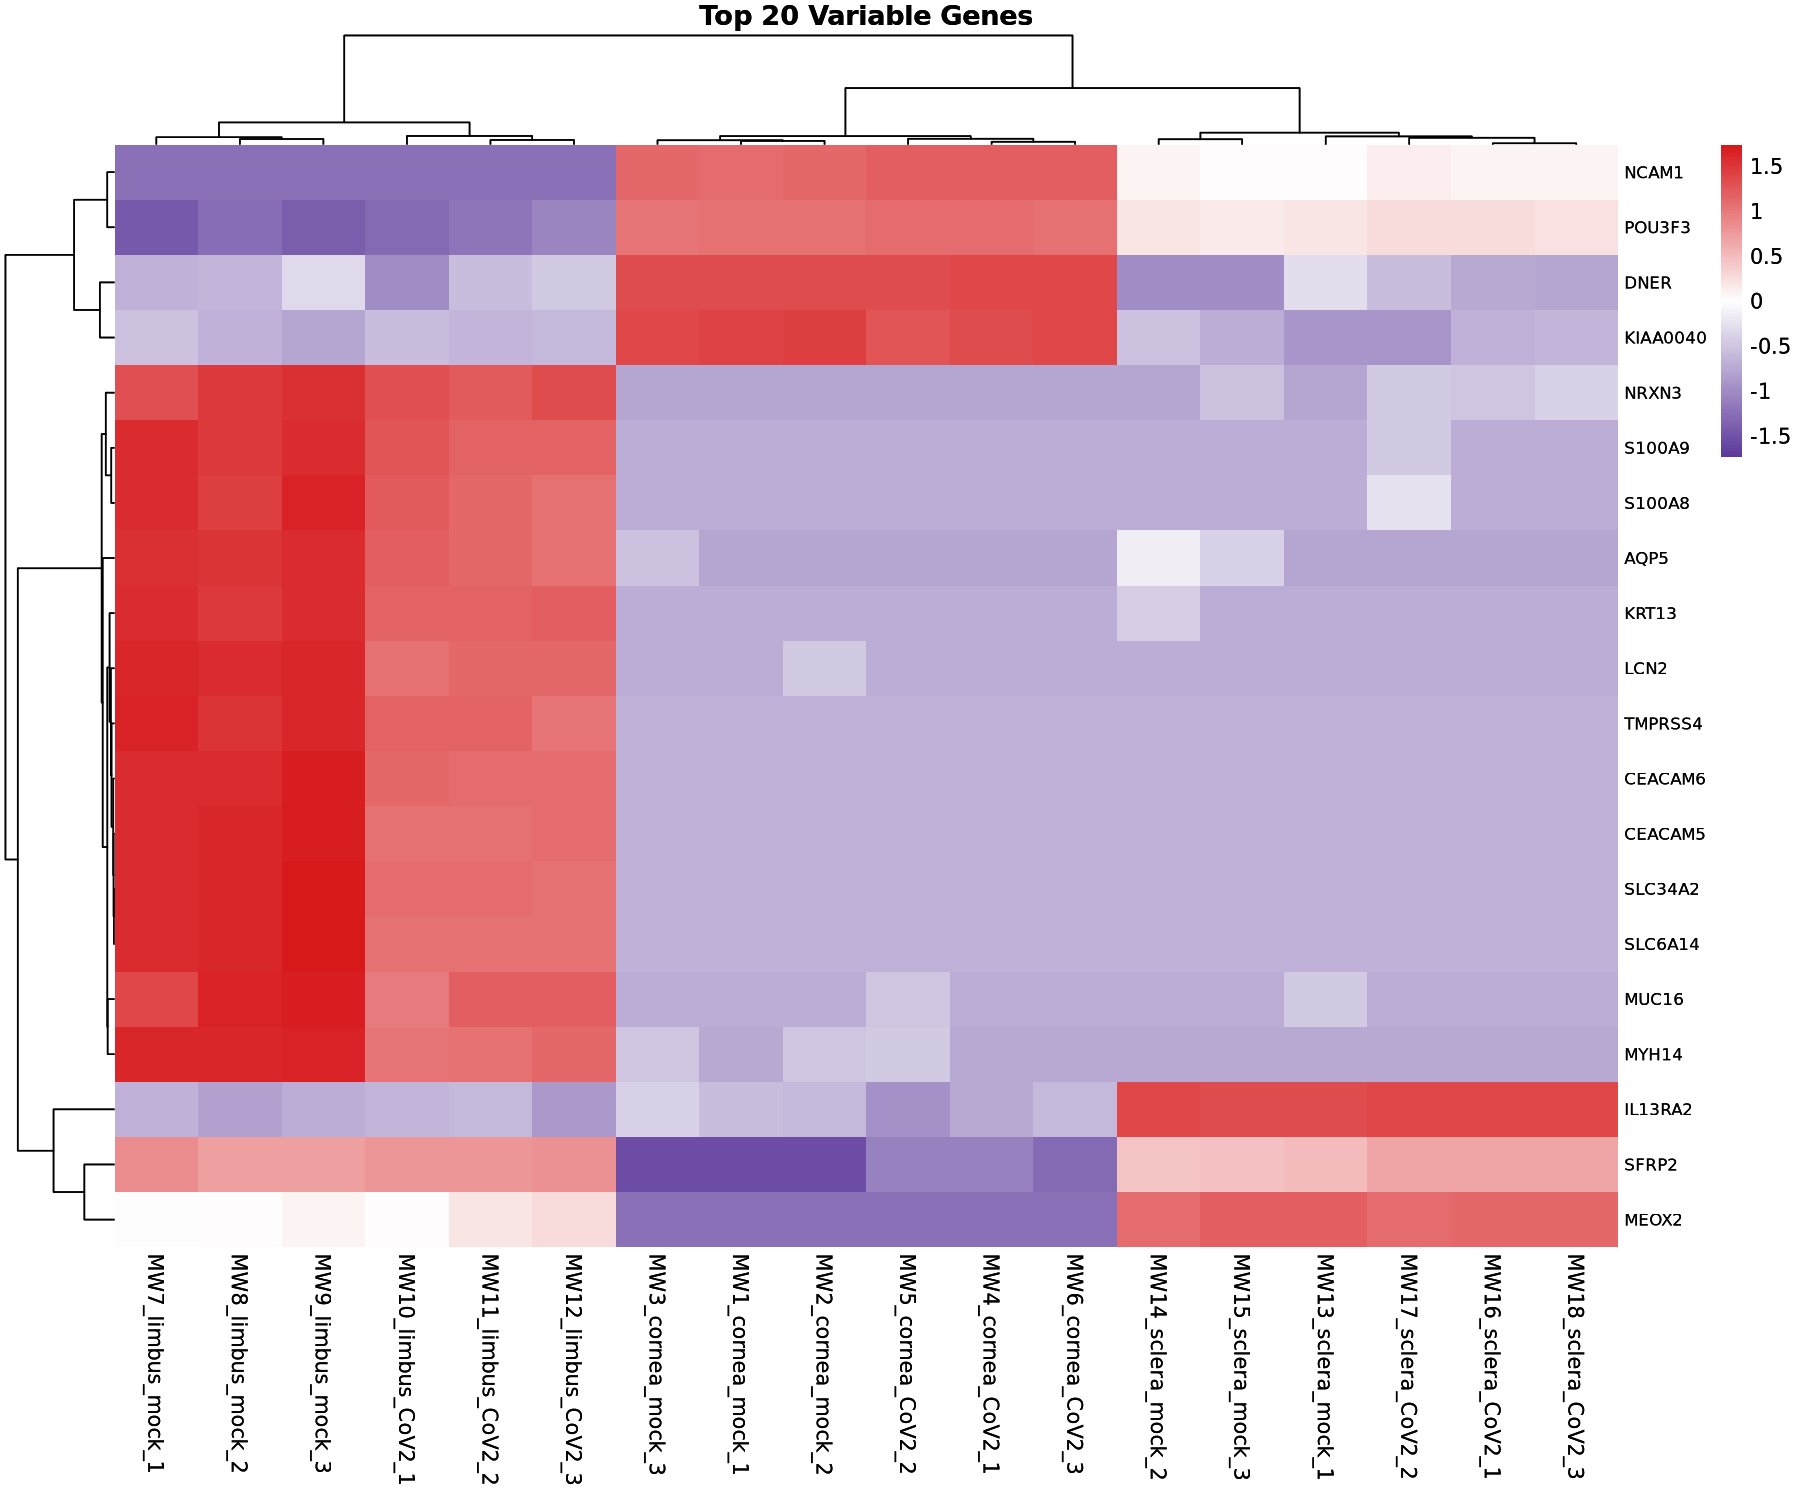

In [37]:
# Normalize counts using DESeq2
log_norm_counts <- log2(counts(dds, normalized = TRUE) + 1)

# Select top 20 variable genes
library(matrixStats)
top_var_genes <- head(order(rowVars(log_norm_counts), decreasing = TRUE), 20)
mat <- log_norm_counts[top_var_genes, ]

# Publication-ready color palette
pub_palette <- colorRampPalette(c("#5D3A9B", "white", "#D7191C"))(100) 

# Draw heatmap
library(pheatmap)
# Set larger display size for notebook
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)

# Draw the heatmap
heatmap <- pheatmap(
  mat,
  scale = "row",
  clustering_distance_rows = "euclidean",
  clustering_distance_cols = "euclidean",
  clustering_method = "complete",
  color = pub_palette,
  show_rownames = TRUE,
  show_colnames = TRUE,
  fontsize_row = 8,
  fontsize_col = 10,
  border_color = NA,
  main = "Top 20 Variable Genes"
)

heatmap



### GO Enrichment Analysis

In [17]:
# Filter the results to get significant DEGs (adjusted p-value < 0.05)
deg <- res[which(res$padj < 0.05), ]
deg_genes <- rownames(deg)


In [18]:
install.packages("devtools")


Installing package into ‘/home/jovyan/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [19]:
devtools::install_github("ctlab/fgsea")
devtools::install_github("GuangchuangYu/DOSE")
devtools::install_github("YuLab-SMU/enrichplot")
devtools::install_github("YuLab-SMU/clusterProfiler")


Skipping install of 'fgsea' from a github remote, the SHA1 (d6f1670c) has not changed since last install.
  Use `force = TRUE` to force installation




Skipping 15 packages ahead of CRAN: zlibbioc, GenomeInfoDbData, GenomeInfoDb, XVector, Biostrings, KEGGREST, S4Vectors, IRanges, Biobase, BiocGenerics, AnnotationDbi, GO.db, BiocParallel, qvalue, GOSemSim



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpuvpfow/remotesf9a5f50b98/YuLab-SMU-DOSE-34a6365/DESCRIPTION’ ... OK
* preparing ‘DOSE’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘DOSE_4.3.0.tar.gz’



Installing package into ‘/home/jovyan/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/Rtmpuvpfow/filef9a772b1570/DOSE_4.3.0.tar.gz’ had non-zero exit status”



Skipping 17 packages ahead of CRAN: zlibbioc, GenomeInfoDbData, GenomeInfoDb, XVector, Biostrings, KEGGREST, S4Vectors, IRanges, Biobase, BiocGenerics, AnnotationDbi, GO.db, BiocParallel, treeio, qvalue, GOSemSim, ggtree



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpuvpfow/remotesf9a53871684/YuLab-SMU-enrichplot-bf86dcd/DESCRIPTION’ ... OK
* preparing ‘enrichplot’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘enrichplot_1.29.2.001.tar.gz’



Installing package into ‘/home/jovyan/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/Rtmpuvpfow/filef9a531dfec3/enrichplot_1.29.2.001.tar.gz’ had non-zero exit status”
Skipping install of 'clusterProfiler' from a github remote, the SHA1 (39395ce1) has not changed since last install.
  Use `force = TRUE` to force installation



In [30]:
# Install Bioconductor package manager if it's not already installed
install.packages("BiocManager")

# Install org.Hs.eg.db
BiocManager::install("org.Hs.eg.db")


Installing package into ‘/home/jovyan/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.26), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'org.Hs.eg.db'”
Old packages: 'DOSE', 'enrichplot', 'AER', 'av', 'boot', 'broom', 'checkmate',
  'collections', 'commonmark', 'cowplot', 'crosstalk', 'curl', 'data.table',
  'Deriv', 'dials', 'doBy', 'doFuture', 'evaluate', 'future', 'future.apply',
  'gert', 'GGally', 'gganimate', 'gghighlight', 'ggpubr', 'ggridges',
  'ggstats', 'glmnet', 'hardhat', 'haven', 'httpuv', 'httr2', 'infer', 'later',
  'mlr', 'modeldata', 'ndjson', 'parallelly', 'parsnip', 'patchwork',
  'pbkrtest', 'pillar', 'plotly',

In [21]:
# Ensure plots render inline
options(jupyter.plot_mimetypes = c("image/png"))




clusterProfiler v4.17.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:dplyr’:

    select






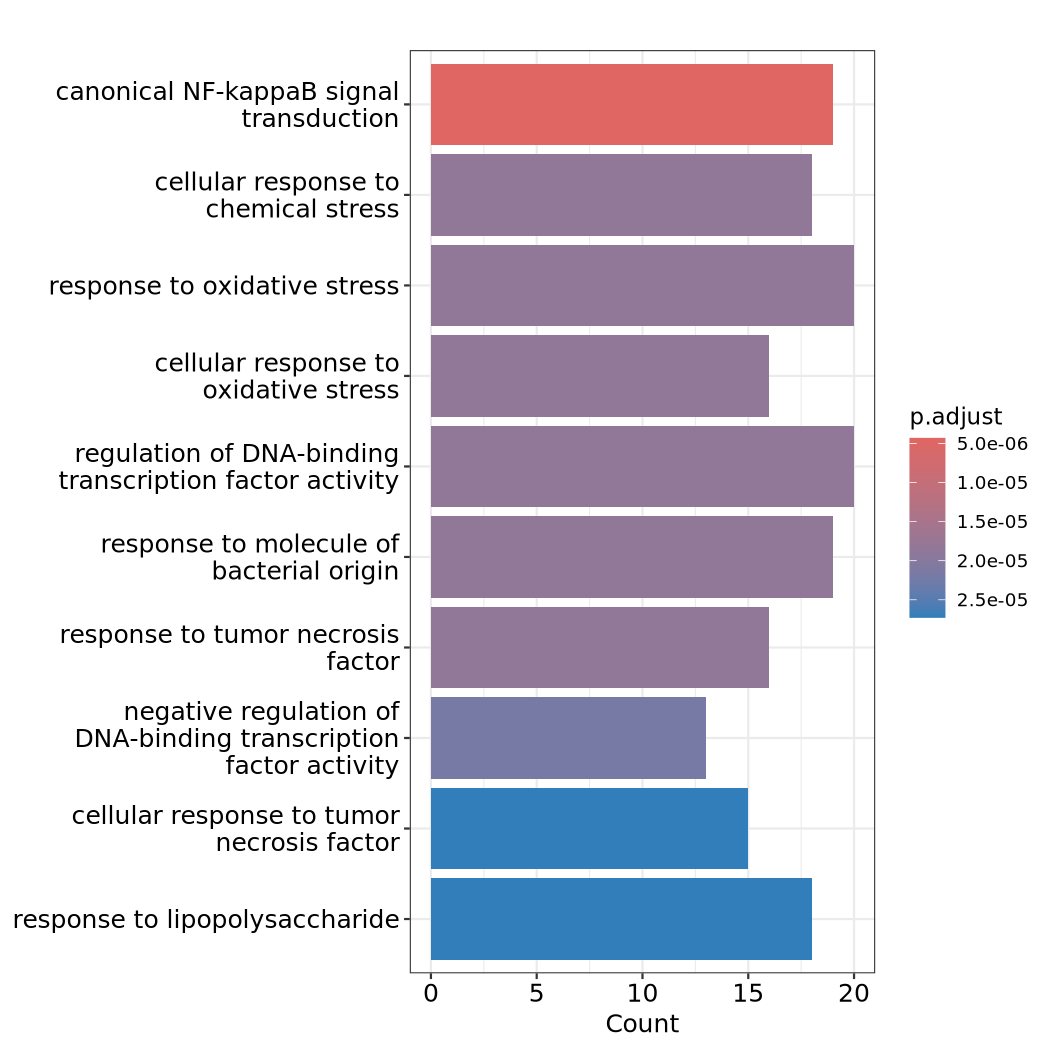

In [22]:
library(clusterProfiler)
library(org.Hs.eg.db)  # Load for human, adjust based on your organism

# Perform GO enrichment analysis (Biological Process - BP, Molecular Function - MF, Cellular Component - CC)
ego <- enrichGO(
  gene = deg_genes,             # DEGs (gene symbols)
  OrgDb = org.Hs.eg.db,         # Organism database
  keyType = "SYMBOL",           # Gene identifier type (e.g., SYMBOL, ENTREZID)
  ont = "BP",                   # Biological Process ontology (can be changed to MF or CC)
  pvalueCutoff = 0.05,          # Adjusted p-value threshold
  qvalueCutoff = 0.2            # FDR threshold (optional)
)

# View the results
#head(ego)
#barplot(ego, color = "p.adjust", showCategory = 10)
